## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

In [4]:
#location of the data 
data_location =  '/home/space/datasets/COA/generated-data-api-smaller'
# data_location =  'generated-data-api'

!ls $data_location

#reading the text data 
import pandas as pd
caption_file = data_location + '/captions.txt'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)


captions.txt  images
There are 50 image to captions


,image,caption
0,image_1.png,A A lion rampant
1,image_2.png,A A lion passt
2,image_3.png,A A lion passt guard
3,image_4.png,A A lion's head
4,image_5.png,A B lion rampant
5,image_6.png,A B lion passt
6,image_7.png,A B lion passt guard


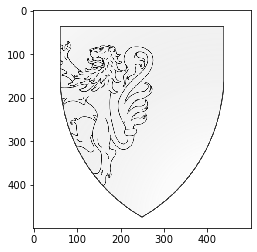

Caption: image_12.png
Caption: image_13.png
Caption: image_14.png
Caption: image_15.png
Caption: image_16.png


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
data_idx = 11

image_path = data_location + '/images/'+ df.iloc[data_idx,0]
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

#image consits of 5 captions,
#showing all 5 captions of the image of the given idx 
for i in range(data_idx,data_idx+5):
    print("Caption:", df.iloc[i,0])


In [6]:
#imports 
import os
import torch
import spacy
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

from PIL import Image


In [7]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080'

In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [9]:
#using spacy for the better text tokenization 
spacy_eng = spacy.blank("en")
# nlp = spacy.load("en_core_web_sm")

#example
text = "A lion rampant"
[token.text.lower() for token in spacy_eng.tokenizer(text)]

# lion and rampant work together 

['a', 'lion', 'rampant']

In [10]:
from src.baseline.vocabulary import Vocabulary

#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab([ 'lion rampant', 'lion passt', 'lion passt guard', "lion's head",
               'cross', 'cross moline', 'cross patonce',
               'eagle', 'eagle doubleheaded',
              'A', 'B', 'O', 'S', 'G', 'E', 'V'])

print(v.stoi)
print(v.numericalize("A lion rampant"))

# Example: “<SOS> A lion rampant <EOS> <PAD> <PAD> <PAD>”

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'lion': 4, 'rampant': 5, 'passt': 6, 'guard': 7, "'s": 8, 'head': 9, 'cross': 10, 'moline': 11, 'patonce': 12, 'eagle': 13, 'doubleheaded': 14, 'a': 15, 'b': 16, 'o': 17, 's': 18, 'g': 19, 'e': 20, 'v': 21}
[15, 4, 5]


In [11]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


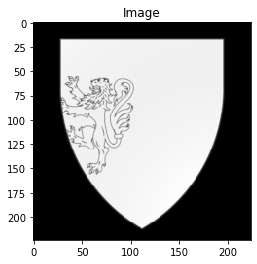

Token: tensor([ 1,  4, 12,  5,  6,  8,  2])
Sentence:
['<SOS>', 'a', 'o', 'lion', 'passt', 'guard', '<EOS>']


In [12]:
from src.baseline.coa_dataset import CoADataset

#defing the transform to be applied
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

#testing the dataset class
dataset =  CoADataset(
    root_dir=data_location+"/images",
    captions_file=data_location+"/captions.txt",
    transform=transforms
)


img, caps = dataset[10]
show_image(img, "Image")
print("Token:", caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [13]:
from src.baseline.caps_collate import CapsCollate

def get_data_loader(dataset,batch_size,num_workers,shuffle=True,batch_first=False):
    #token to represent the padding
    pad_idx = dataset.vocab.stoi["<PAD>"]

    return DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=batch_first)
)

# setting the constants
BATCH_SIZE = 4
NUM_WORKER = 0 # when put to 1, an error happens: DataLoader worker (pid(s) 7203) exited unexpectedly - kernel crushes

# writing the dataloader
data_loader = get_data_loader(dataset,BATCH_SIZE,NUM_WORKER,True,True)

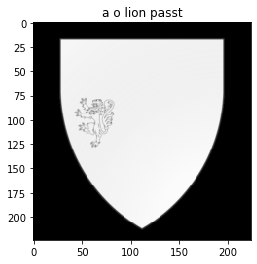

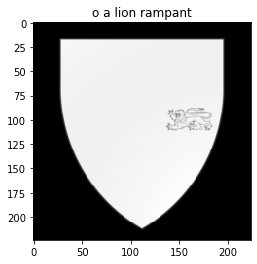

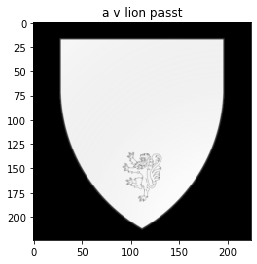

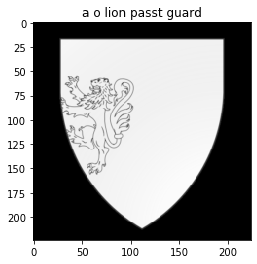

In [14]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show()


# Image Captioning With Attention - Pytorch

In [15]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [16]:
#Initiate the Dataset and Dataloader

#setting the constants
BATCH_SIZE = 10
NUM_WORKER = 0

#defining the transform to be applied
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
dataset =  CoADataset(
    root_dir = data_location+"/images",
    captions_file = caption_file,
    transform=transforms
)

#writing the dataloader
data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
)


In [17]:

#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

In [19]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader,Dataset
# imports 
from src.baseline.encoder_cnn import EncoderCNN
from src.baseline.attention import Attention
from src.baseline.decoder_rnn import DecoderRNN
from src.baseline.encoder_decoder import EncoderDecoder

### Setting Hypperparameter and Init the model

In [20]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [21]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/salnabulsi/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
#helper function to save the model
def save_model(model,num_epochs, model_full_path):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,model_full_path)

## Training Job from above configs

Epoch: 1 loss: 0.23458


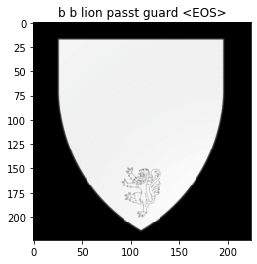

Epoch: 2 loss: 0.30533


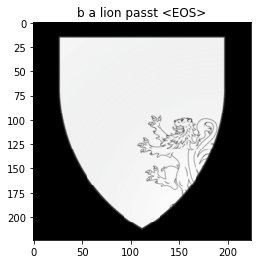

Epoch: 3 loss: 0.24064


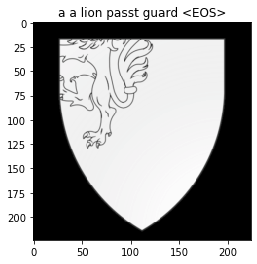

Epoch: 4 loss: 0.17463


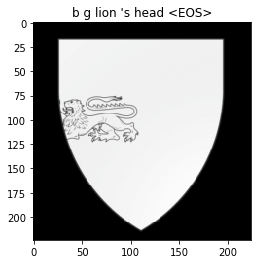

Epoch: 5 loss: 0.24254


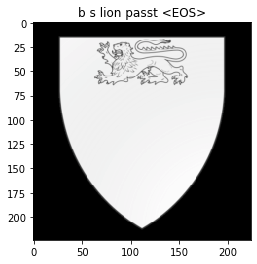

Epoch: 6 loss: 0.41627


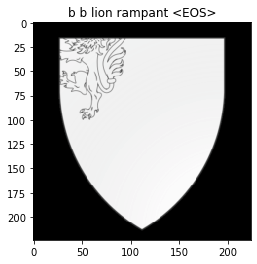

Epoch: 7 loss: 0.23005


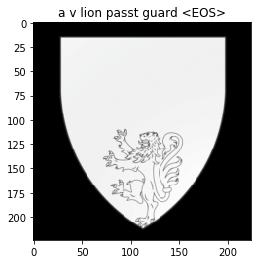

Epoch: 8 loss: 0.20065


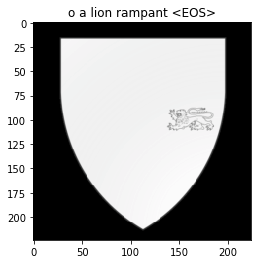

Epoch: 9 loss: 0.22749


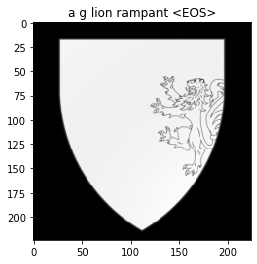

Epoch: 10 loss: 0.17615


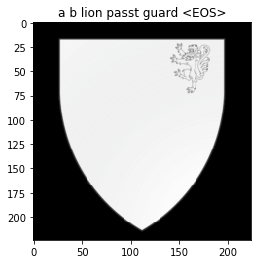

Epoch: 11 loss: 0.13992


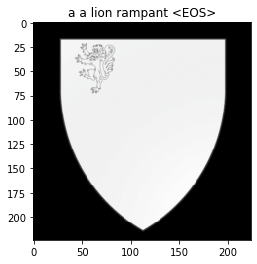

Epoch: 12 loss: 0.17015


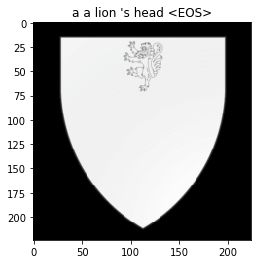

Epoch: 13 loss: 0.16826


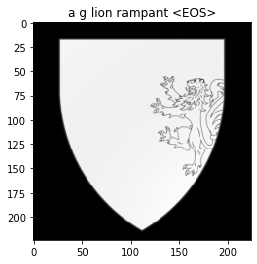

Epoch: 14 loss: 0.15433


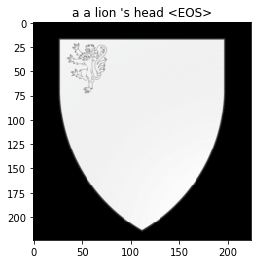

Epoch: 15 loss: 0.16909


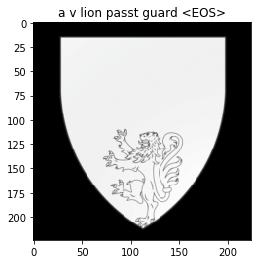

Epoch: 16 loss: 0.13339


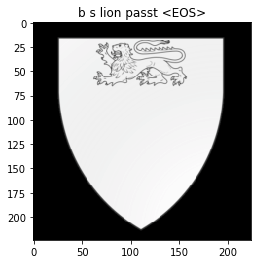

Epoch: 17 loss: 0.09522


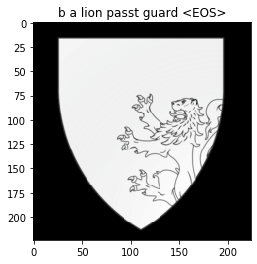

Epoch: 18 loss: 0.17763


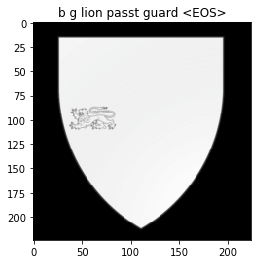

Epoch: 19 loss: 0.08132


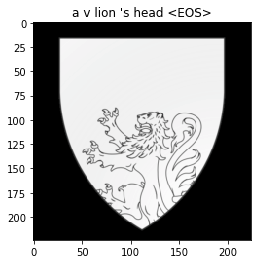

Epoch: 20 loss: 0.16670


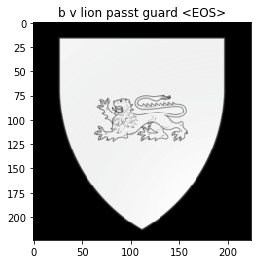

Epoch: 21 loss: 0.13144


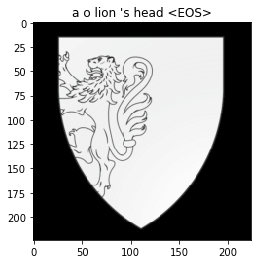

Epoch: 22 loss: 0.14333


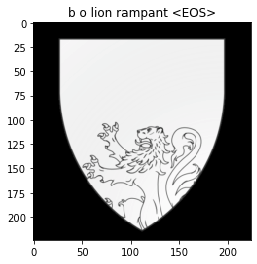

Epoch: 23 loss: 0.11081


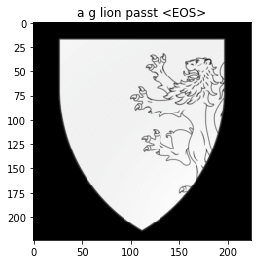

Epoch: 24 loss: 0.08577


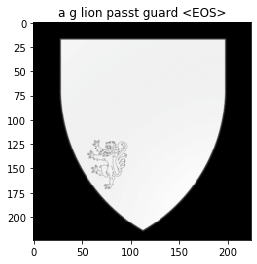

Epoch: 25 loss: 0.09949


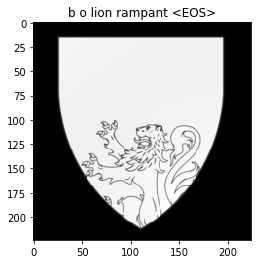

In [26]:
num_epochs = 25
print_every = 5

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions.T) ####### the fix in here

        # Calculate the batch loss.
        targets = captions.T[:,1:]  ####### the fix in here
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
        
    #save the latest model
    save_model(model,epoch, '/home/space/datasets/COA/models/baseline/attention_model_state-smaller-50.pth')

##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [41]:
import torch
import torch.onnx as onnx
import torchvision.models as models


def load_trainder_model(model_path):
    # the values here are unimportant as they will be overwritten later
    model = EncoderDecoder(
        embed_size=300,
        vocab_size = len(dataset.vocab),
        attention_dim=256,
        encoder_dim=2048,
        decoder_dim=512
    ).to(device)

    torch.save(model.state_dict(),model_path)
    
    return model

model_path = '/home/space/datasets/COA/models/baseline/attention_model_state-smaller-50.pth'
model = load_trainder_model(model_path)

In [42]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

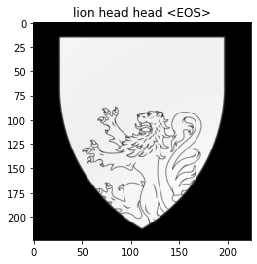

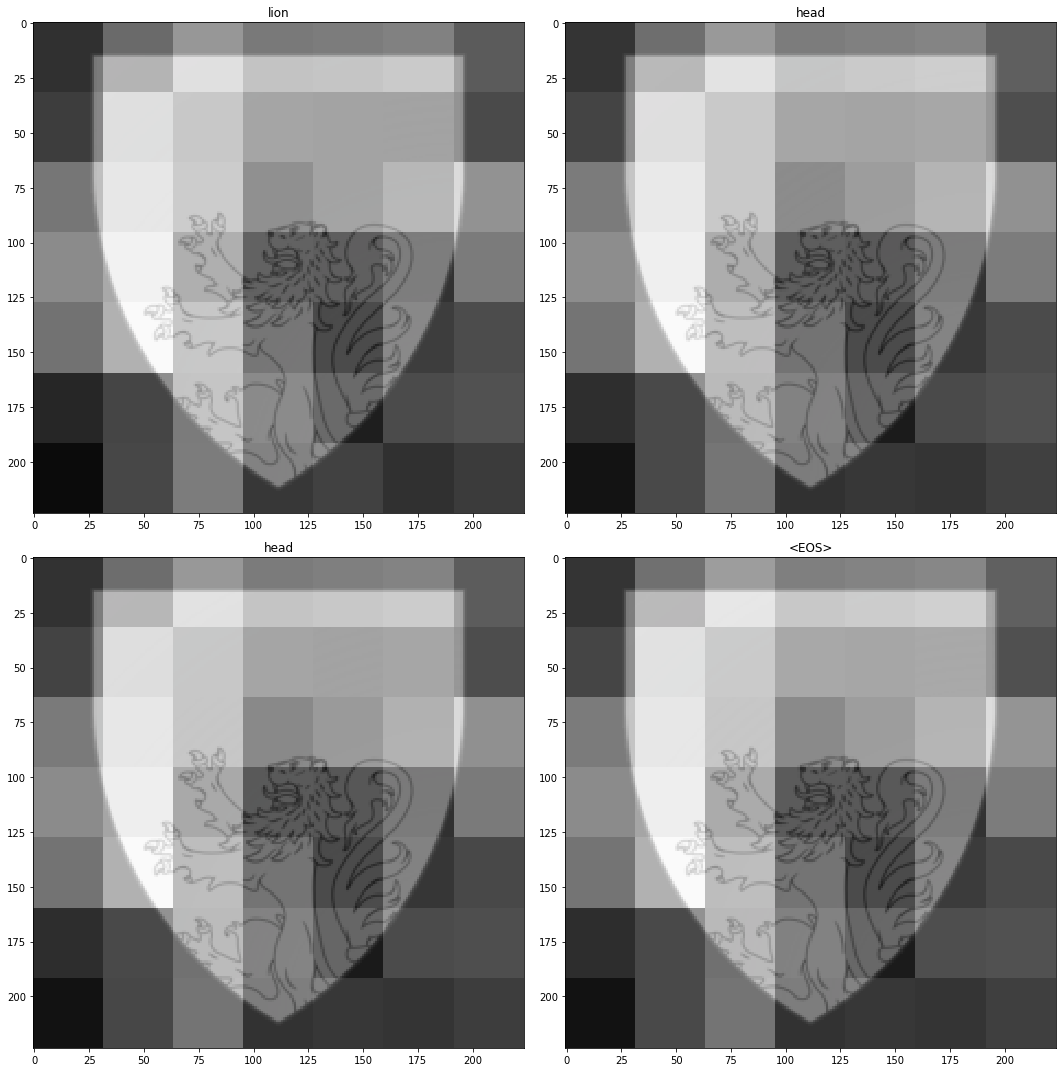

In [43]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

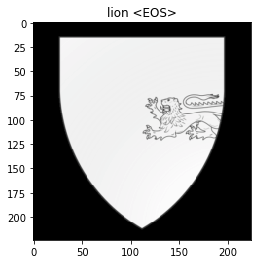

ValueError: num must be 1 <= num <= 1, not 2

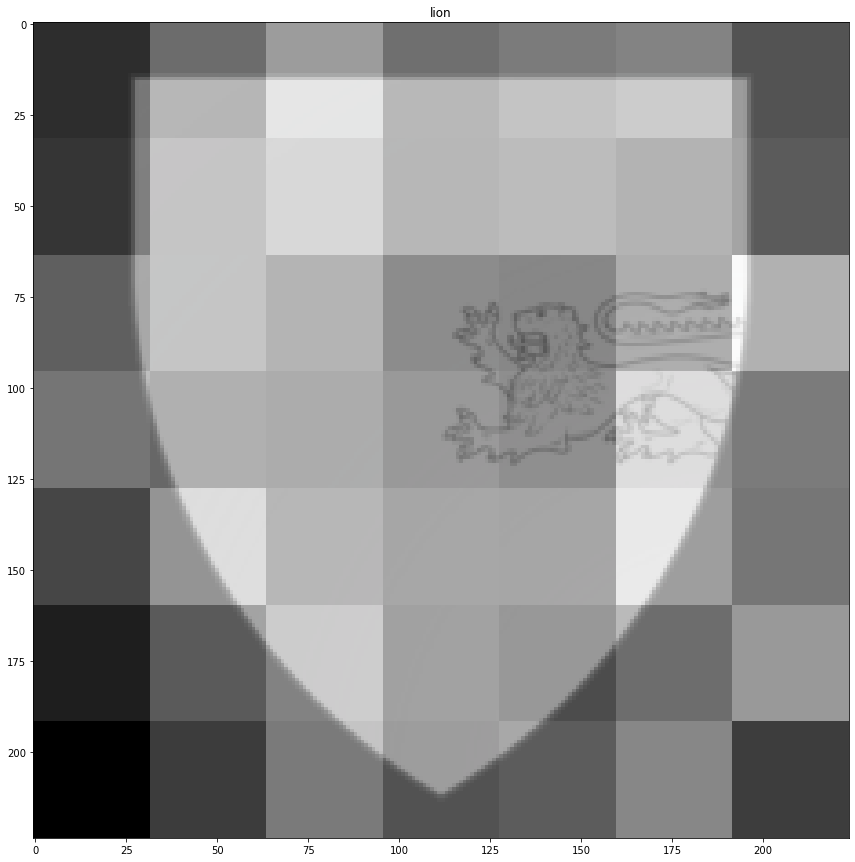

In [45]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

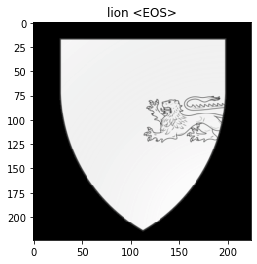

ValueError: num must be 1 <= num <= 1, not 2

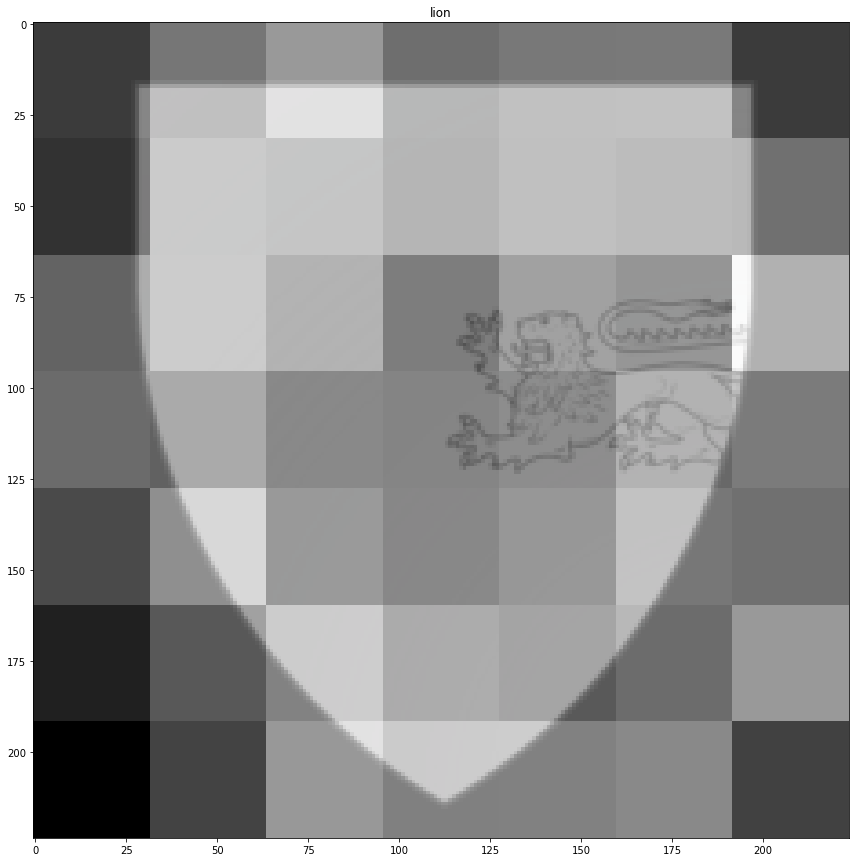

In [46]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)